# Tuning parameters:
* pipline
* parameters tuning
* validation curve: find appropriate model complexity 
* training curve: find good amount of data

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, validation_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
df = pd.read_csv('../Data/wisconsin_cancer.data', header=None)

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

enc = LabelEncoder()
y = enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

## Pipline

In [22]:
pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)), ('lr', LogisticRegression(random_state=17))]) 
pipe_lr.fit(X_train, y_train)
print('Accuracy on test: %.3f' % pipe_lr.score(X_test, y_test))

Accuracy on test: 0.965


## Train-Validate-Test

**Train-Test**

The first approach for model validation is simply separate dataset to the training and test. But this approach despite attractive simplicity has problems:
* the result directly depends on the separation on training and test sets
* if we repeat tunning several times, the model learns the test data set and can overfit



**Train-Validate-Test**

Idea is very similar, train model on train dataset, tune parameters on validation dataset, check results on test dataset. Problem of this approach the same: 
* the result directly depends on the separation on training validation and test sets



**K-Fold cross-validation**

Mentioned before problems can be solved with *K-Fold cross-validation*. 
Idea of methos is foolowing:
* separate data into k groups of the same length
* k-1 of them will be used at each iteration for training and one (k-th) for testing
* training will be done k times, thus we get k models trained on different part of data
* the results are averaged over all obtained model
* in practice, k is taken from 3 to 10

**Leave-one-out (LOO)**

*LOO* is a variation of K-Fold cross-validation, but it is used, when we have very small amount of data. $k$ is equal to the length of data, so that only one training sample is used for testing during each iteration.

**Stratified K-Fold cross-validation**

*Stratified K-Fold cross-validation* - is a variation of K-Fold cross-validation where each subset contains approximately the same percentage of samples of each target class.

*General function*

In [43]:
from sklearn.model_selection import StratifiedKFold 

kfold = StratifiedKFold(n_splits=10, random_state=17)
scores = []

for train_index, test_index in kfold.split(X_train, y_train):
    pipe_lr.fit(X_train[train_index], y_train[train_index])
    score = pipe_lr.score(X_train[test_index], y_train[test_index]) 
    scores.append(score)
    
print(f'Mean score {round(np.mean(scores),3)}.')

Mean score 0.945.


In [44]:
from sklearn.model_selection import cross_val_score 

scores = cross_val_score(estimator=pipe_lr,X=X_train, y=y_train, cv=10, n_jobs=-1)

print(f'Mean score {round(np.mean(scores),3)}.')

Mean score 0.945.


*Function for logistic regression*

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-10, 10, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_train, y_train)

c_best = c_values[np.argmax(np.mean(np.squeeze(list(logit_searcher.scores_.values()), axis=0), axis=0))]

print(f'Best parameter{c_best}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameter5.514205739240302


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


In [54]:
print(f'Mean score {round(max(np.mean(np.squeeze(list(logit_searcher.scores_.values()), axis=0), axis=0)),3)}') 

Mean score 0.96


## Tuning parameters: grid search

There are some special functions which can help us to find good hyperparameters of the model.

In [58]:
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)

logit_pipe = Pipeline([('scaler', StandardScaler()), ('sgd_logit', sgd_logit)])

alphas = {'sgd_logit__alpha': np.logspace(-2, 0, 20)}

grid_logit_pipe = GridSearchCV(logit_pipe, alphas, cv=5, n_jobs=-1)
grid_logit_pipe.fit(X_train, y_train)

print(f'Best score in validation: {grid_logit_pipe.best_score_}, \nBest parameters: {grid_logit_pipe.best_params_}, \nScore on hold-out data: {accuracy_score(grid_logit_pipe.best_estimator_.predict(X_test), y_test)}')

Best score in validation: 0.9758241758241759, 
Best parameters: {'sgd_logit__alpha': 0.012742749857031334}, 
Score on hold-out data: 0.9736842105263158


## Validation curve: tune the complexity of the model

The validation curve is a graph showing the result on the training and validation sets, depending on the complexity of the model:

* if two curves are close together and both errors are large, this is a sign of under-learning
* if two curves are far apart, this is an indicator of overfitting

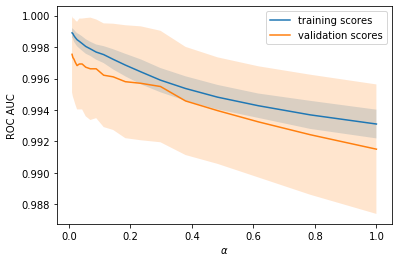

In [67]:
alphas_2 = np.logspace(-2, 0, 20)

val_train, val_test = validation_curve(logit_pipe, X_train, y_train, 'sgd_logit__alpha', alphas_2, cv=5, scoring='roc_auc')

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',facecolor=lines[0].get_color(), alpha=0.2)
    
plot_with_err(alphas_2, val_train, label='training scores')
plot_with_err(alphas_2, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend()
plt.show();

What conclusion can be made in our case? The distance between the curves does not change, which means there is no overfitting here. Moreover, with an increase in the parameter, the error increases in both samples, which indicates under-training. Thus, a parameter close to zero is suitable for us. Let's consider this piece in more detail.

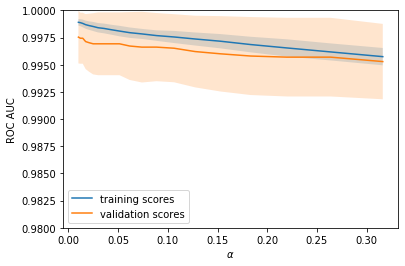

In [75]:
alphas_2 = np.logspace(-2, -0.5, 20)

val_train, val_test = validation_curve(logit_pipe, X_train, y_train, 'sgd_logit__alpha', alphas_2, cv=5, scoring='roc_auc')
    
plot_with_err(alphas_2, val_train, label='training scores')
plot_with_err(alphas_2, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend()
plt.ylim([0.98, 1])
plt.show;

## Learning curve: tune the amount of data

The learning curve is a graph showing the results on validation and training subsets depending on the number of observations:

* If the curves converge, adding new data will not help - you need to change the complexity of the model.
* If the curves have not yet converged, adding new data can improve the result.

In [83]:
train_sizes = np.linspace(0.05, 1, 20)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=0.02))])
N_train, val_train, val_test = learning_curve(logit_pipe, X_train, y_train, train_sizes=train_sizes, cv=5,scoring='roc_auc')

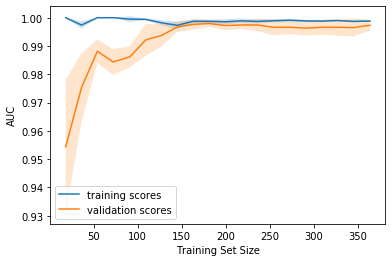

In [80]:
plot_with_err(N_train, val_train, label='training scores')
plot_with_err(N_train, val_test, label='validation scores')
plt.xlabel('Training Set Size'); plt.ylabel('AUC')
plt.legend()
plt.show;

In our case, the model was first under-learned, then gradually the curves converge, which means adding data can't  help any more in this case.